In [2]:
import numpy as np
import pymc3 as pm

import pickle
from datetime import datetime


import seaborn as sns
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fp2 = FontProperties(fname=r"../../fonts/Font Awesome 5 Free-Solid-900.otf")

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.models import add_cms_to_plot
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

sns.set_style("ticks")
%matplotlib inline

In [1]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("../final_data/data_final.csv")

NameError: name 'DataPreprocessor' is not defined

In [7]:
regions = ["DE", "HU", "FI", "IE", "RS", "BE"]

cm_plot_style = [
                # ("\uf7f2", "tab:red"),  # hospital symbol
                ("\uf963", "black"),  # mask
                ("\uf492", "mediumblue"),  # vial
                ("\uf0c0", "lightgrey"),  # ppl
                ("\uf0c0", "grey"),  # ppl
                ("\uf0c0", "black"),  # ppl
                ("\uf07a", "tab:orange"),  # shop 1
                ("\uf07a", "tab:red"),  # shop2
                ("\uf19d", "black"),  # school
                ("\uf965", "black")  # home
            ]

In [ ]:
traces = [pickle.load(open(f, "rb")) for f in ["exp05_diff_effects.pkl"]]

In [19]:
def region_plot(region, data):
    print(region)
    try:
        res = pickle.load(open(f"{region}.pkl", "rb"))
    except:
        print(f"{region} missing")
        return
    r_i = data.Rs.index(region)
    mask_region(data, region)

    means_ic, lu_ic, up_ic, err_ic = produce_CIs(
        res.InfectedCases
    )

    ec = res.ExpectedCases
    nS, nDs = ec.shape
    dist = pm.NegativeBinomial.dist(mu=ec, alpha=47)
    ec_output = dist.random()

    means_ec, lu_ec, up_ec, err_ec = produce_CIs(
        ec_output
    )

    ids = res.InfectedDeaths
    ed = res.ExpectedDeaths
    nS, nDs = ed.shape
    dist = pm.NegativeBinomial.dist(mu=ed, alpha=47)
    
    try:
        ed_output = dist.random()
    except:
        ed_output = np.ones_like(ed) * 10 ** -8
        ids = np.ones_like(ids) * 10 ** -8
    
    means_id, lu_id, up_id, err_id = produce_CIs(
        ids
    )
    
    means_ed, lu_ed, up_ed, err_ed = produce_CIs(
        ed_output
    )

    days = data.Ds
    days_x = np.arange(len(days))

    min_x = 25
    max_x = len(days) - 1

    newcases = data.NewCases[r_i, :]
    deaths = data.NewDeaths[r_i, :]

    ax = plt.gca()
    plt.plot(
        days_x,
        means_ic,
        label="Daily Infected - Cases",
        zorder=1,
        color="tab:purple",
        alpha=0.25
    )

    plt.fill_between(
        days_x, lu_ic, up_ic, alpha=0.15, color="tab:purple", linewidth=0
    )

    plt.plot(
        days_x,
        means_ec,
        label="Predicted New Cases",
        zorder=2,
        color="tab:blue"
    )

    plt.fill_between(
        days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
    )

    plt.scatter(
        np.arange(len(deaths)),
        newcases,
        label="New Cases (Smoothed)",
        marker="o",
        s=10,
        color="tab:blue",
        alpha=0.9,
        zorder=3,
    )

    plt.scatter(
        np.arange(len(deaths)),
        newcases.data,
        label="Heldout New Cases (Smoothed)",
        marker="o",
        s=12,
        edgecolor="tab:blue",
        facecolor="white",
        linewidth=1,
        alpha=0.9,
        zorder=2,
    )

    plt.plot(
        days_x,
        means_id,
        label="Daily Infected - Deaths",
        zorder=1,
        color="tab:orange",
        alpha=0.25
    )

    plt.fill_between(
        days_x, lu_id, up_id, alpha=0.15, color="tab:orange", linewidth=0
    )

    plt.plot(
        days_x,
        means_ed,
        label="Estimated Deaths",
        zorder=2,
        color="tab:red"
    )

    plt.fill_between(
        days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
    )

    plt.scatter(
        np.arange(len(deaths)),
        deaths,
        label="New Deaths (Smoothed)",
        marker="o",
        s=10,
        color="tab:red",
        alpha=0.9,
        zorder=3,
    )

    plt.scatter(
        np.arange(len(deaths)),
        deaths.data,
        label="Heldout New Deaths (Smoothed)",
        marker="o",
        s=12,
        edgecolor="tab:red",
        facecolor="white",
        linewidth=1,
        alpha=0.9,
        zorder=2,
    )
    
    plt.title(f"{data.RNames[region][0]}")
    ax.set_yscale("log")
    plt.xlim([min_x, max_x])
    plt.ylim([10 ** 0, 10 ** 6])
    locs = np.arange(min_x, max_x, 7)
    xlabels = [f"{days[ts].day}-{days[ts].month}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30)
    ax = plt.gca()
    ax1 = add_cms_to_plot(ax, data.ActiveCMs, r_i, min_x, max_x, days, cm_plot_style)
    return ax

In [20]:
regions

['CZ', 'DE', 'MX', 'NL', 'PL', 'PT']

CZ
DE
MX
NL
PL
PT


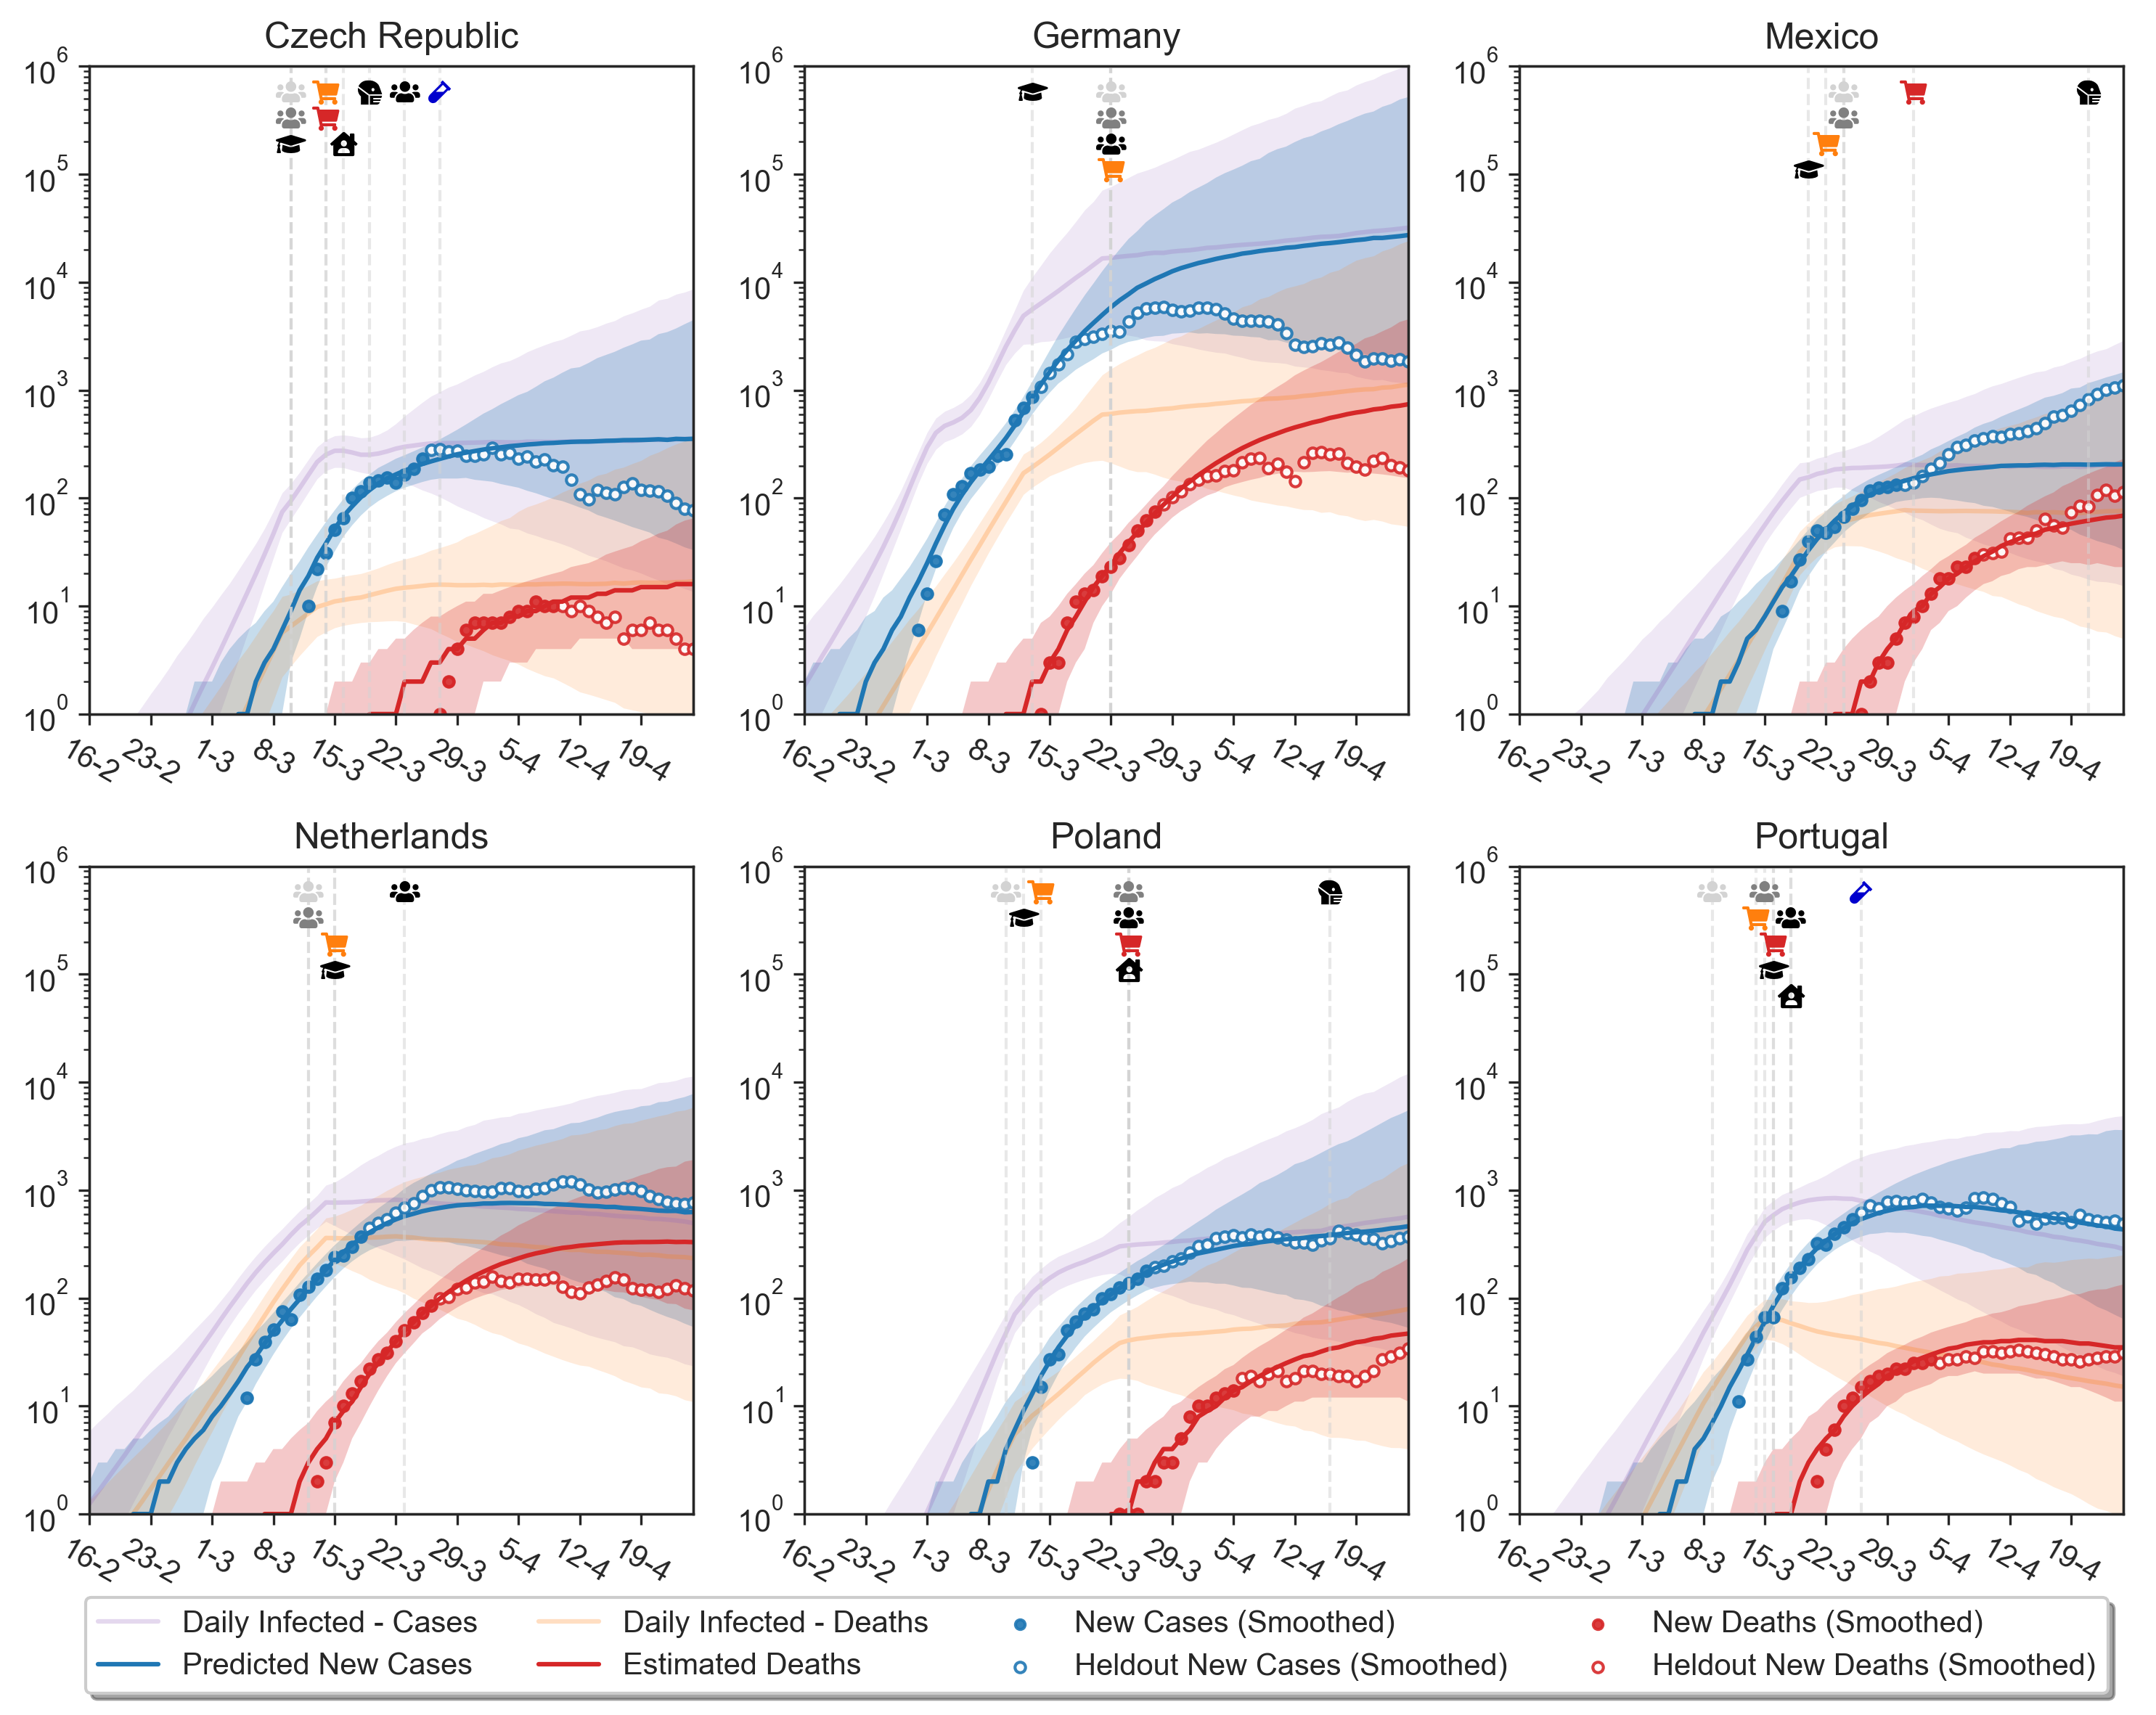

In [21]:
plt.figure(figsize=(10, 7.5), dpi=300)

for i, rg in enumerate(regions):
    plt.subplot(2,3,i+1)
    if i == 5:
        ax = region_plot(rg, data)
    else:
        region_plot(rg, data)

plt.tight_layout()    
ax.legend(prop={"size": 10}, loc="lower center", shadow=True, fancybox=True, ncol=4, bbox_to_anchor=(-0.7, -0.3));
plt.savefig("FigHO.pdf", bbox_inches="tight")

AL
AD
AT
BE
BA
BG
HR
CZ
DK
EE
FI
FR


FR
GE
DE
GR
HU
IS
IE
IL
IT
LV
LT
MY
MT


MT
MX
MA
NL
NZ
NO
PL
PT
RO
RS
SG
SK
SI


SI
ZA
ES
SE
CH
GB


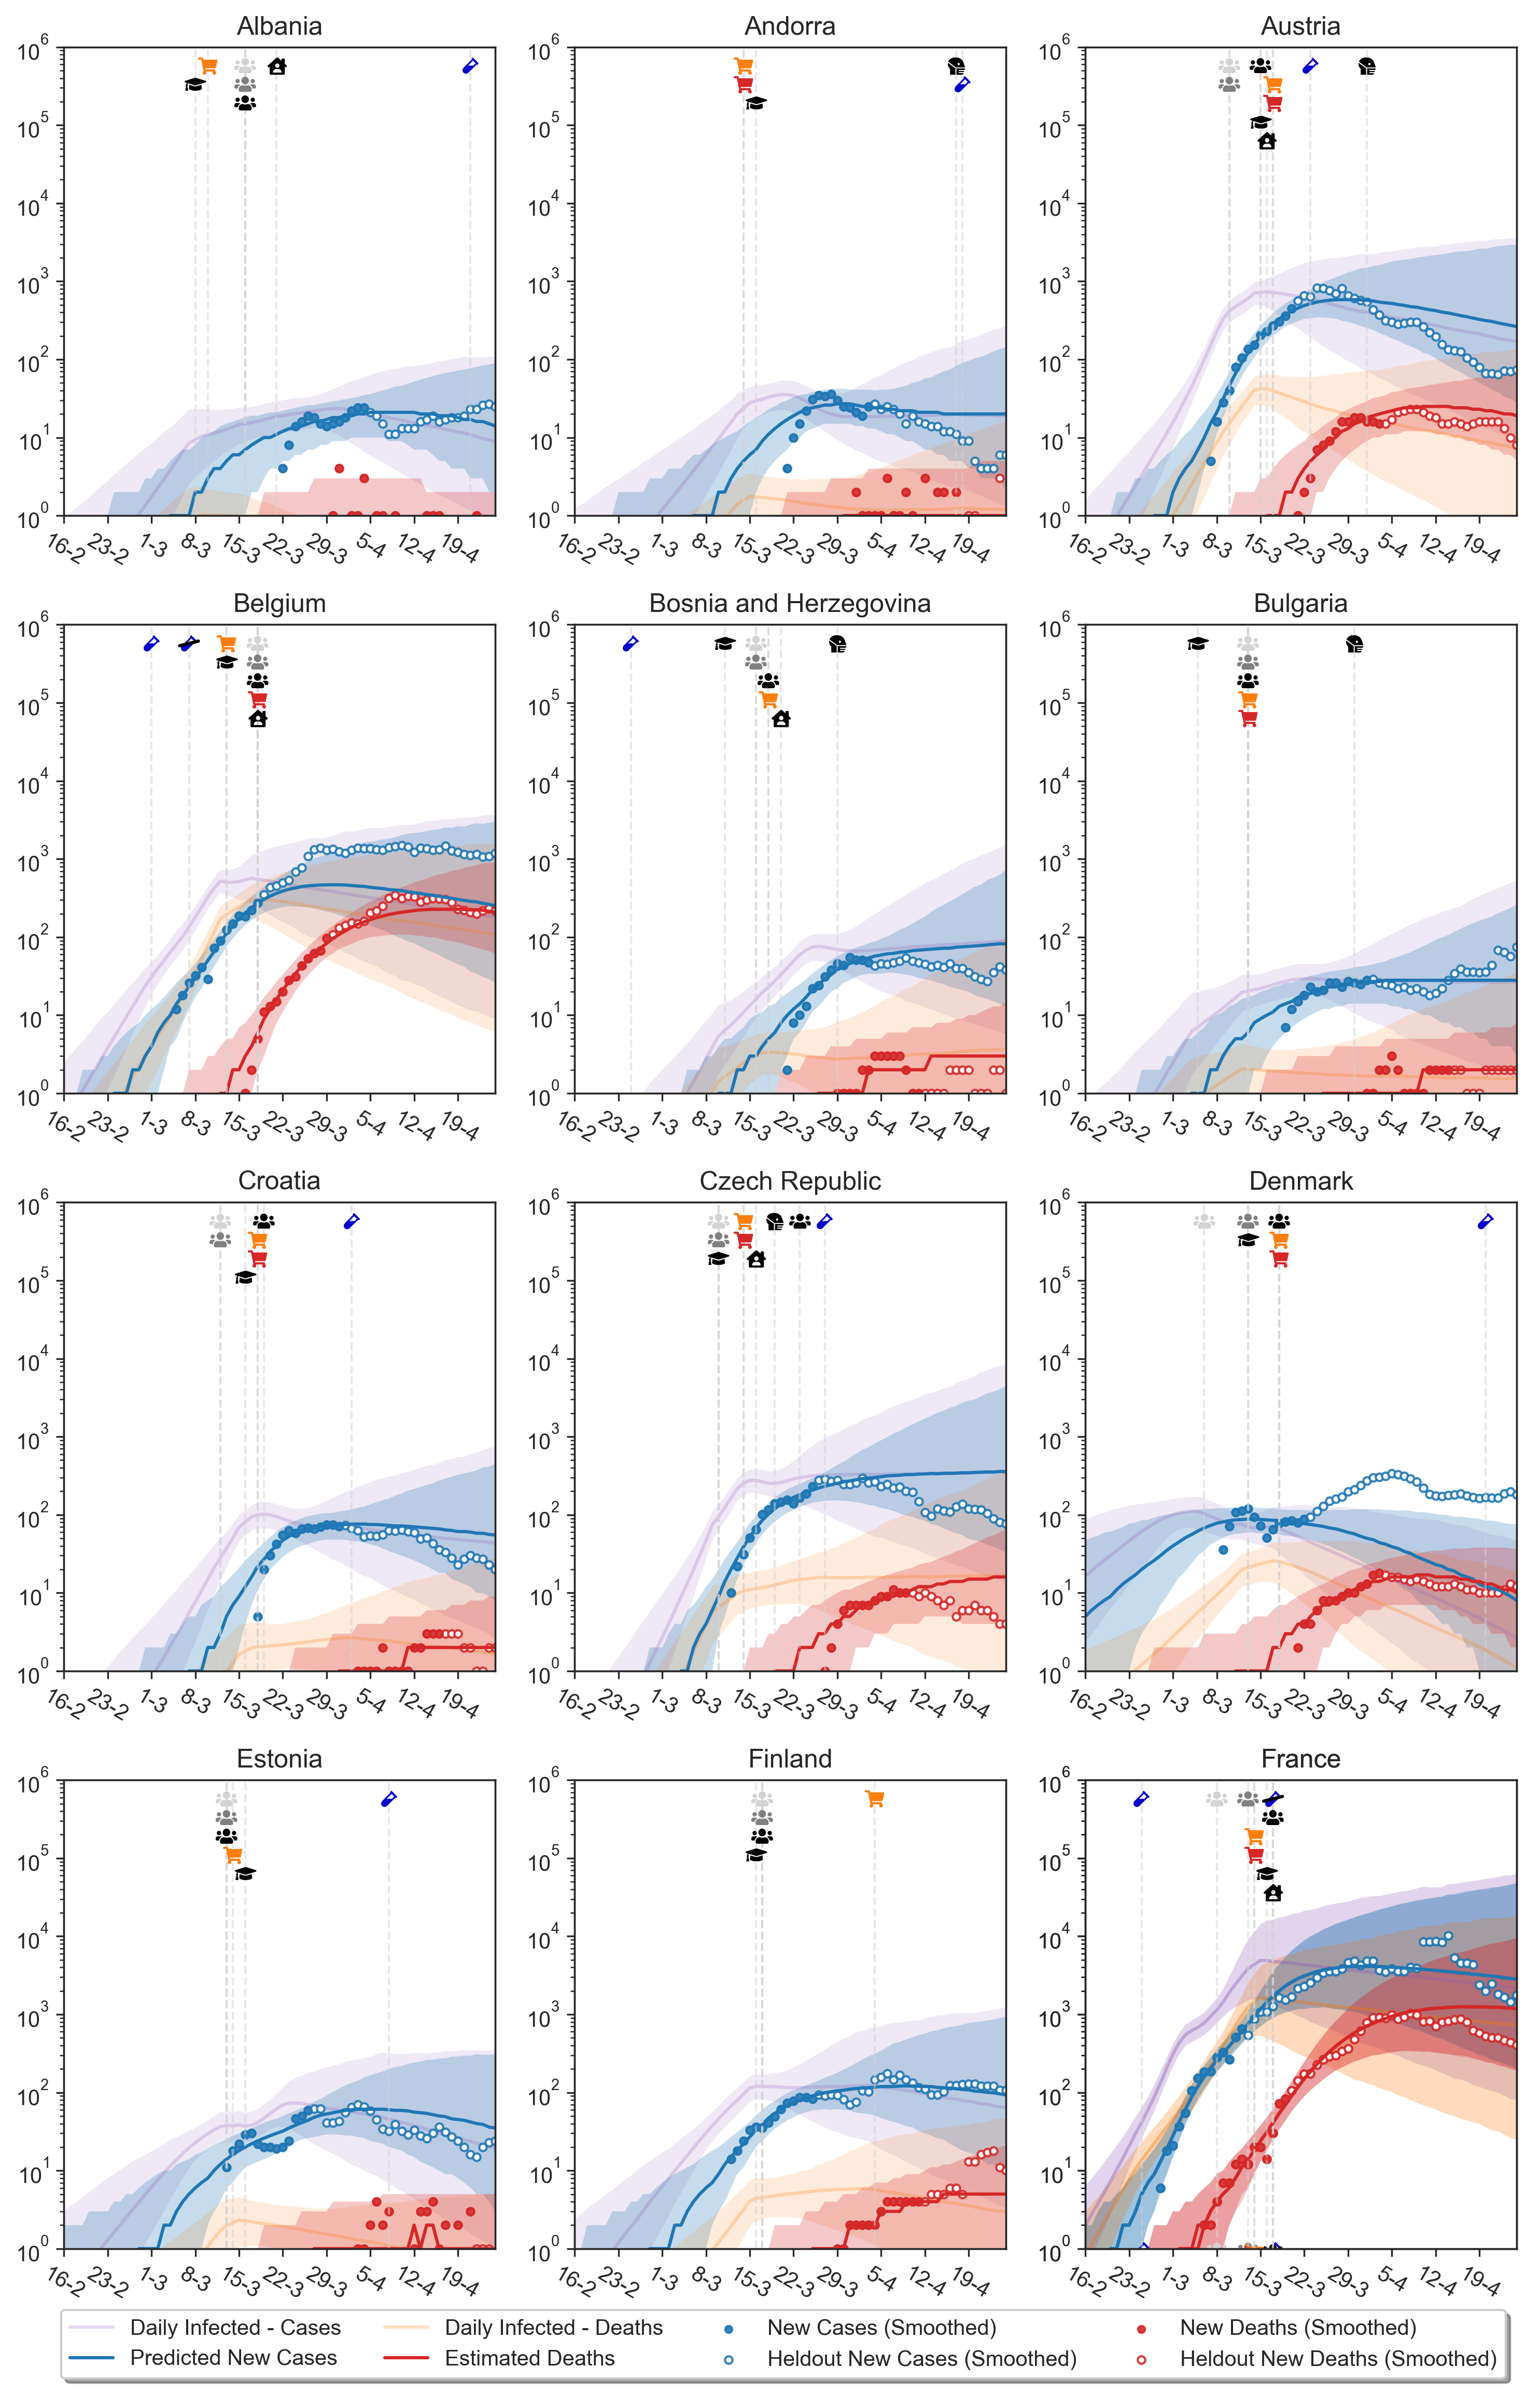

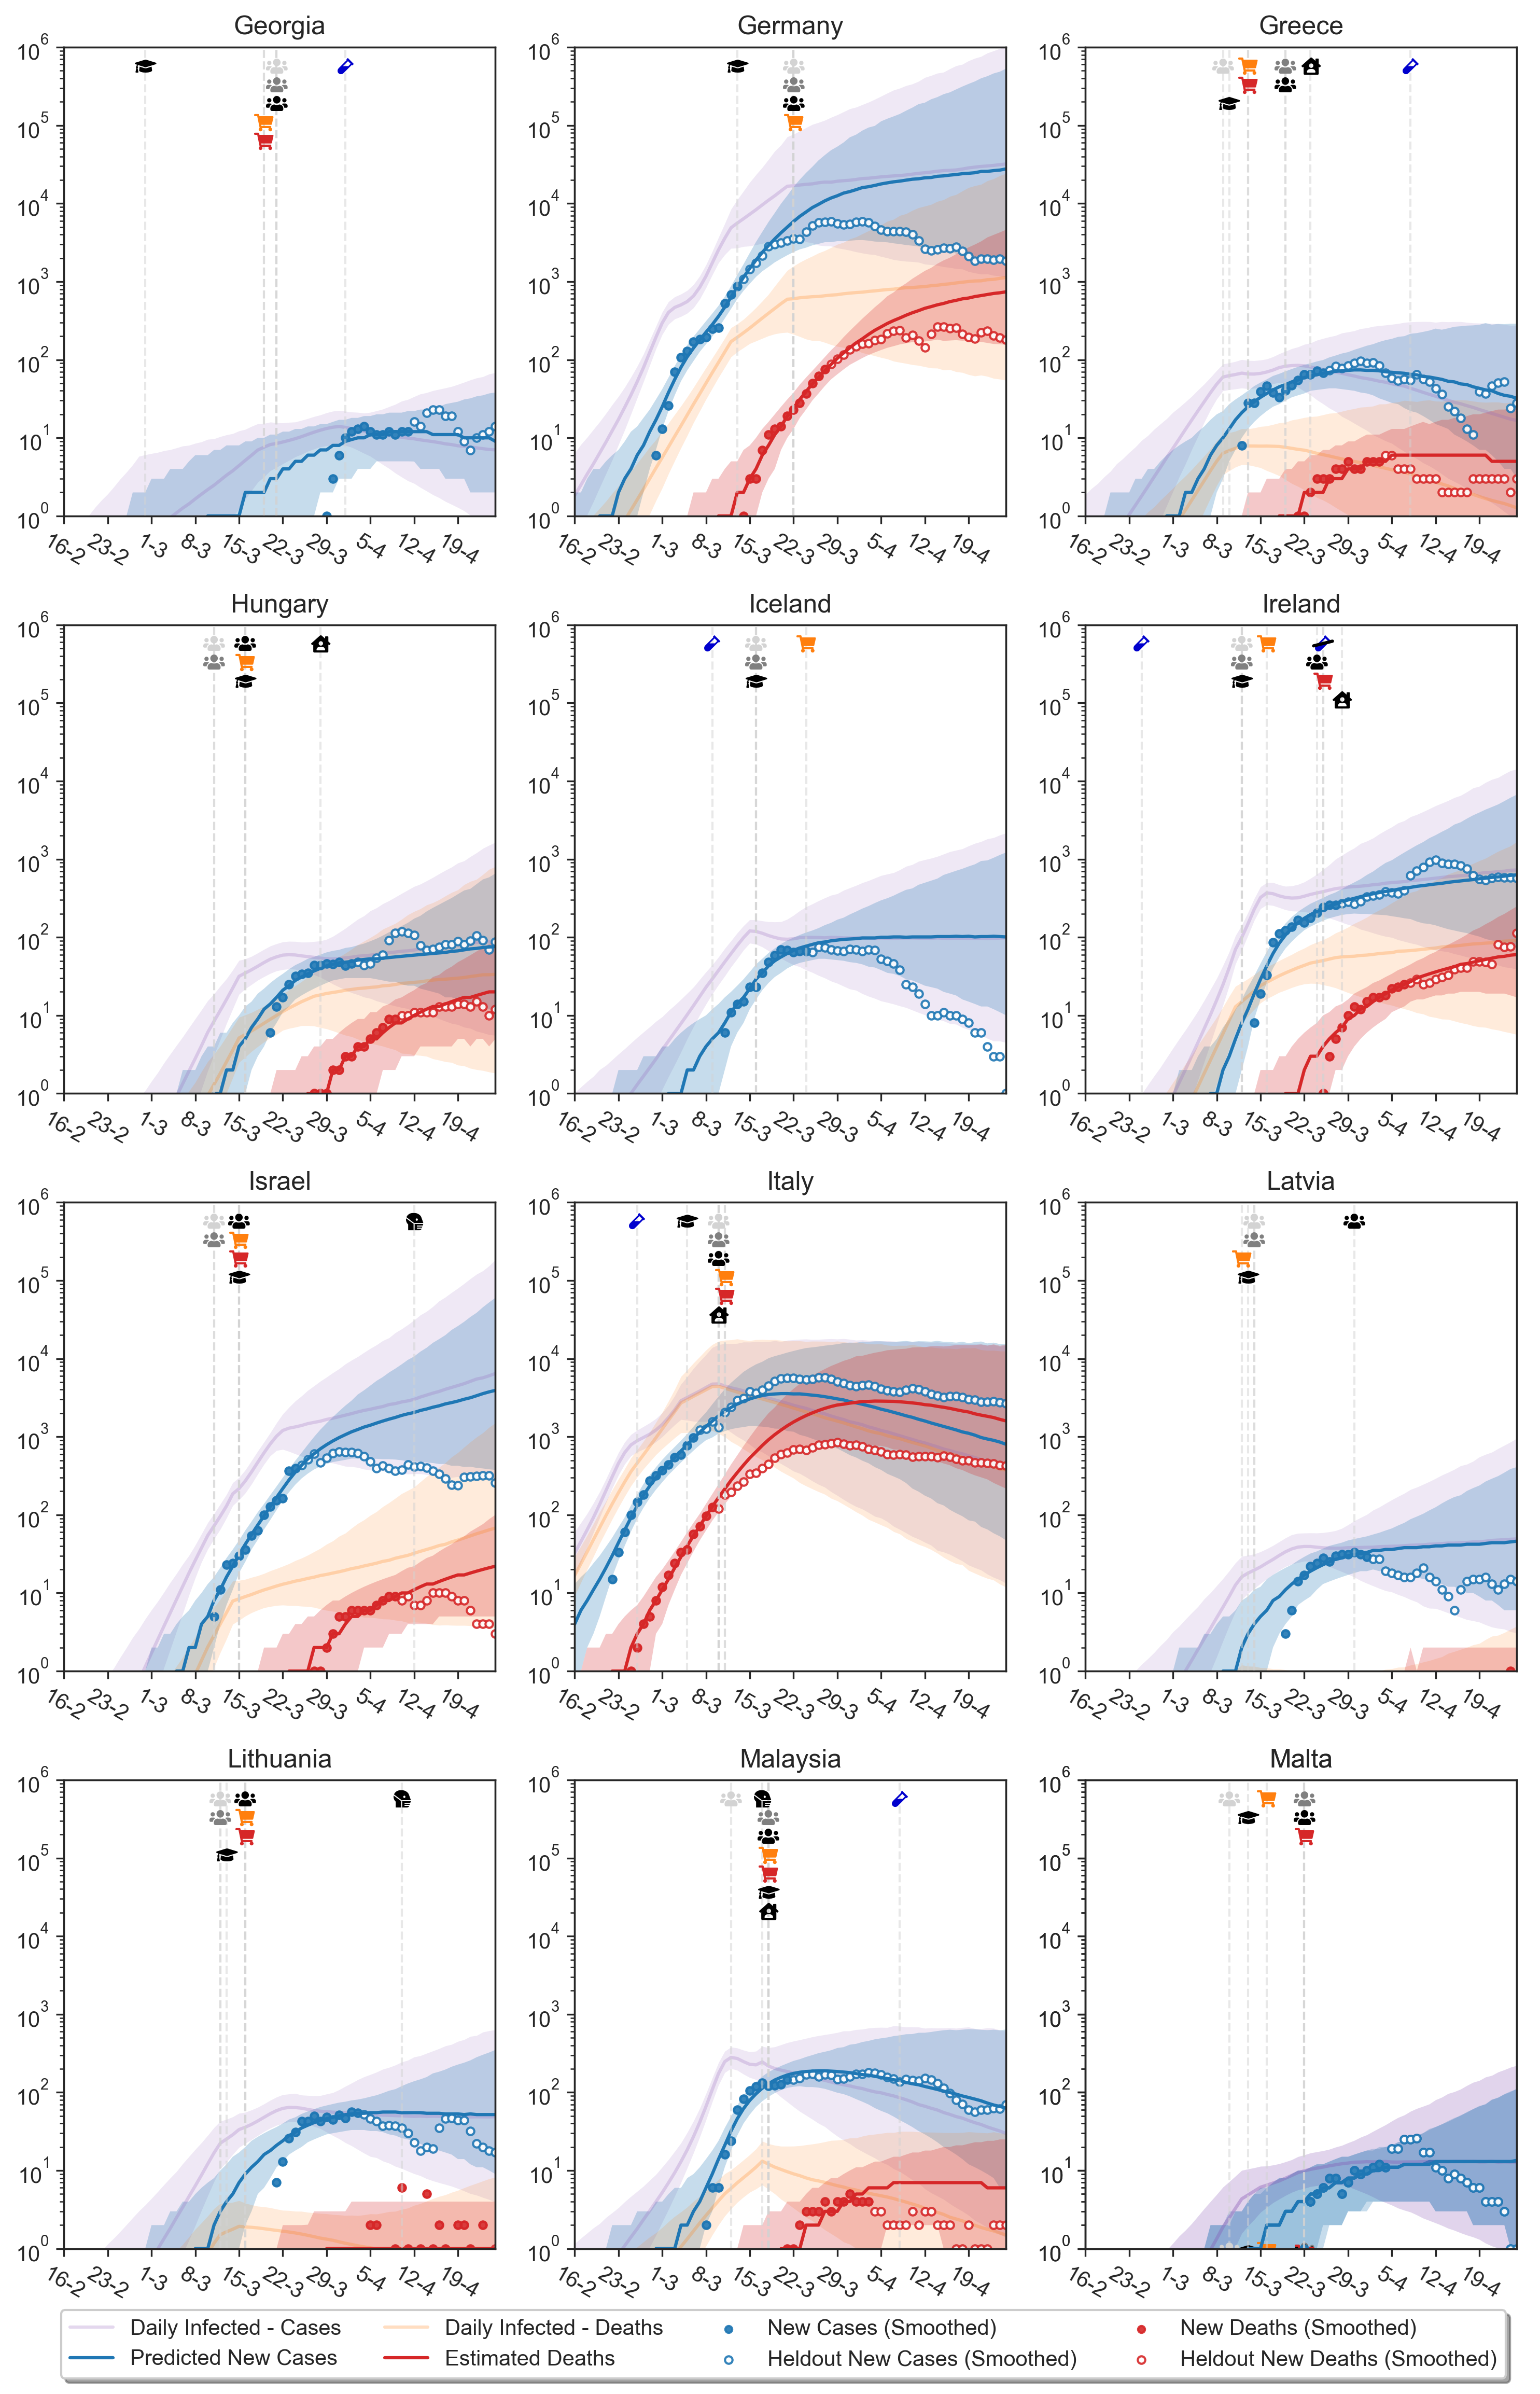

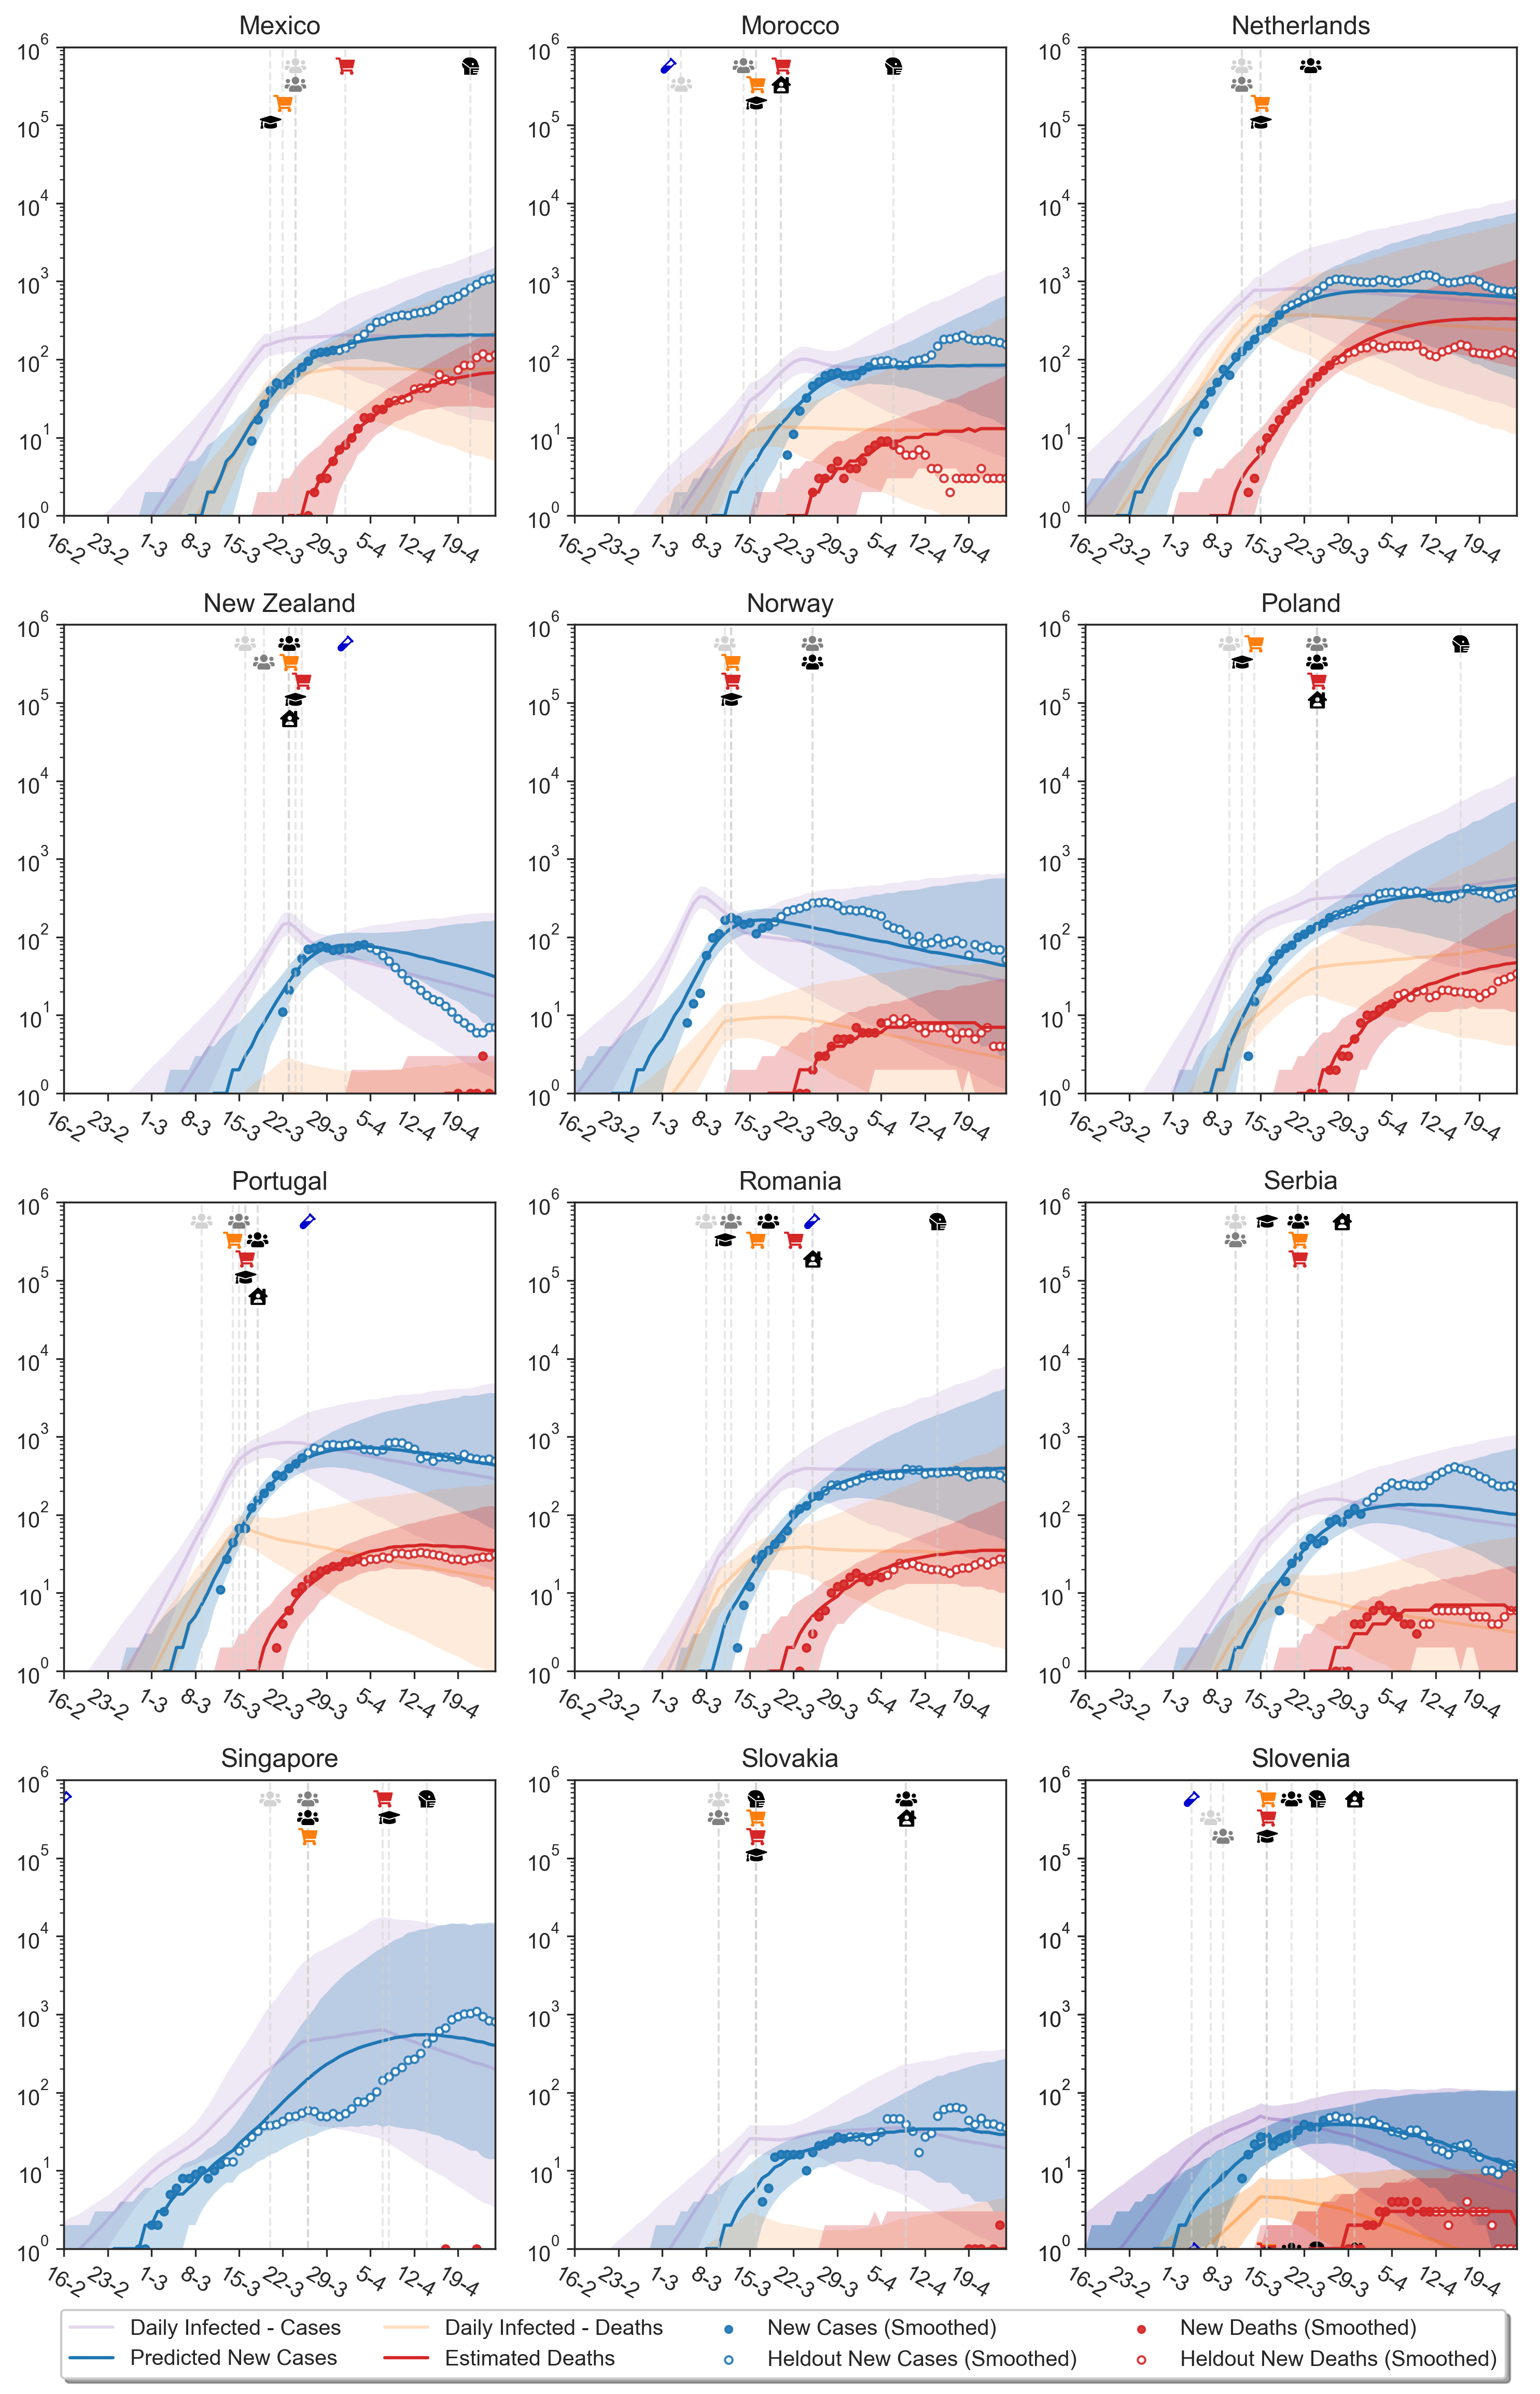

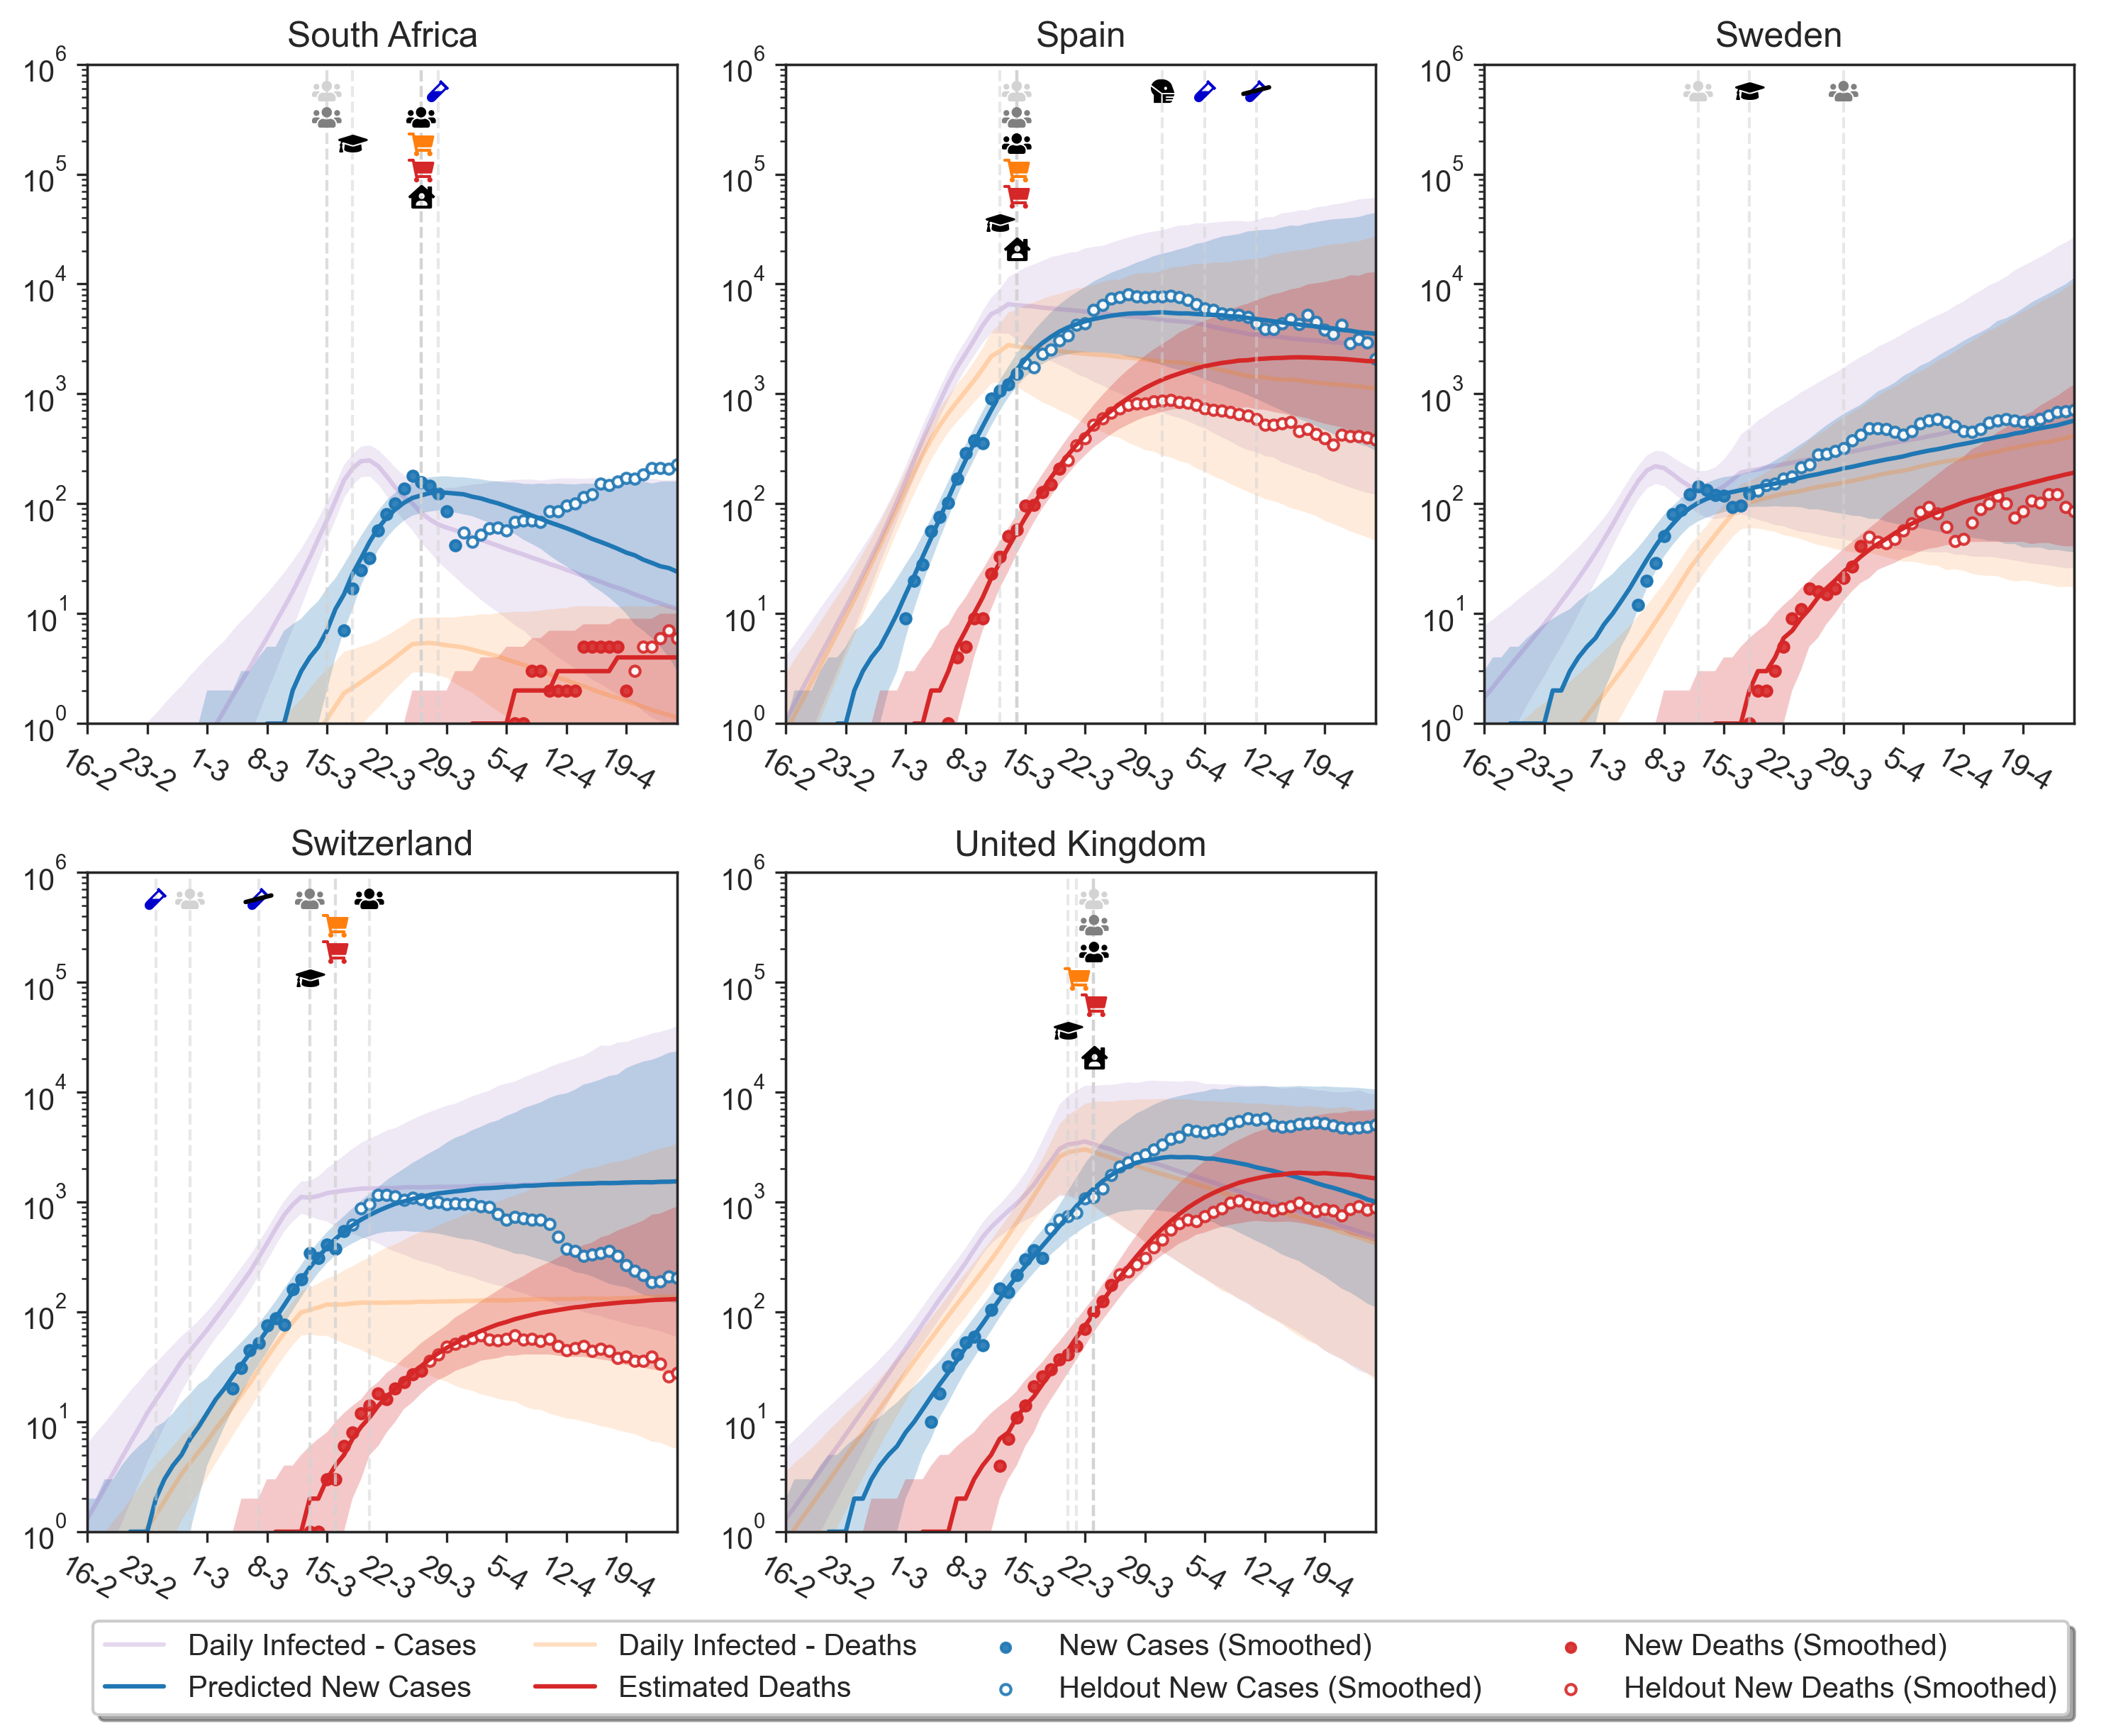

In [22]:
for i, rg in enumerate(data.Rs):
    if i % 12 == 0:
        plt.figure(figsize=(10, 15), dpi=300)
    plt.subplot(4,3,(i%12)+1)
    if i % 12 == 11:
        ax = region_plot(rg, data)
        plt.tight_layout()    
        ax.legend(prop={"size": 10}, loc="lower center", shadow=True, fancybox=True, ncol=4, bbox_to_anchor=(-0.7, -0.3));
        plt.savefig(f"HOSet{(np.ceil(i/12))}.pdf", bbox_inches='tight')
    if i+1 == len(data.Rs):
        ax = region_plot(rg, data)
        plt.tight_layout()
        ax.legend(prop={"size": 10}, loc="lower center", shadow=True, fancybox=True, ncol=4, bbox_to_anchor=(0.5, -0.3));
        plt.savefig(f"HOSet{(np.ceil(i/12))}.pdf", bbox_inches='tight')
    else:
        region_plot(rg, data)

In [23]:
regions = ["CZ", "DE", "MX", "NL", "PL", "PT"]

In [5]:
def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq

derived_features = [
 ("Mask Wearing", [1-1]),
 ("Symptomatic Testing", [2-1]),
 ("Gatherings <1000", [3-1]),
 ("Gatherings <100", [3-1, 4-1]),
 ("Gatherings <10", [3-1, 4-1, 5-1]),
 ("Some Businesses Suspended", [6-1]),
 ("Most Businesses Suspended", [6-1, 7-1]),
 ("School Closure", [8-1]),
 ("Stay Home Order", [9-1]),  
 ]

cm_plot_style = [
#                 ("\uf7f2", "tab:red"),  # hospital symbol
                ("\uf963", "black"),  # mask
                ("\uf492", "mediumblue"),  # vial
                ("\uf0c0", "lightgrey"),  # ppl
                ("\uf0c0", "grey"),  # ppl
                ("\uf0c0", "black"),  # ppl
                ("\uf07a", "tab:orange"),  # shop 1
                ("\uf07a", "tab:red"),  # shop2
                ("\uf19d", "black"),  # school
                ("\uf965", "black")  # home
            ]

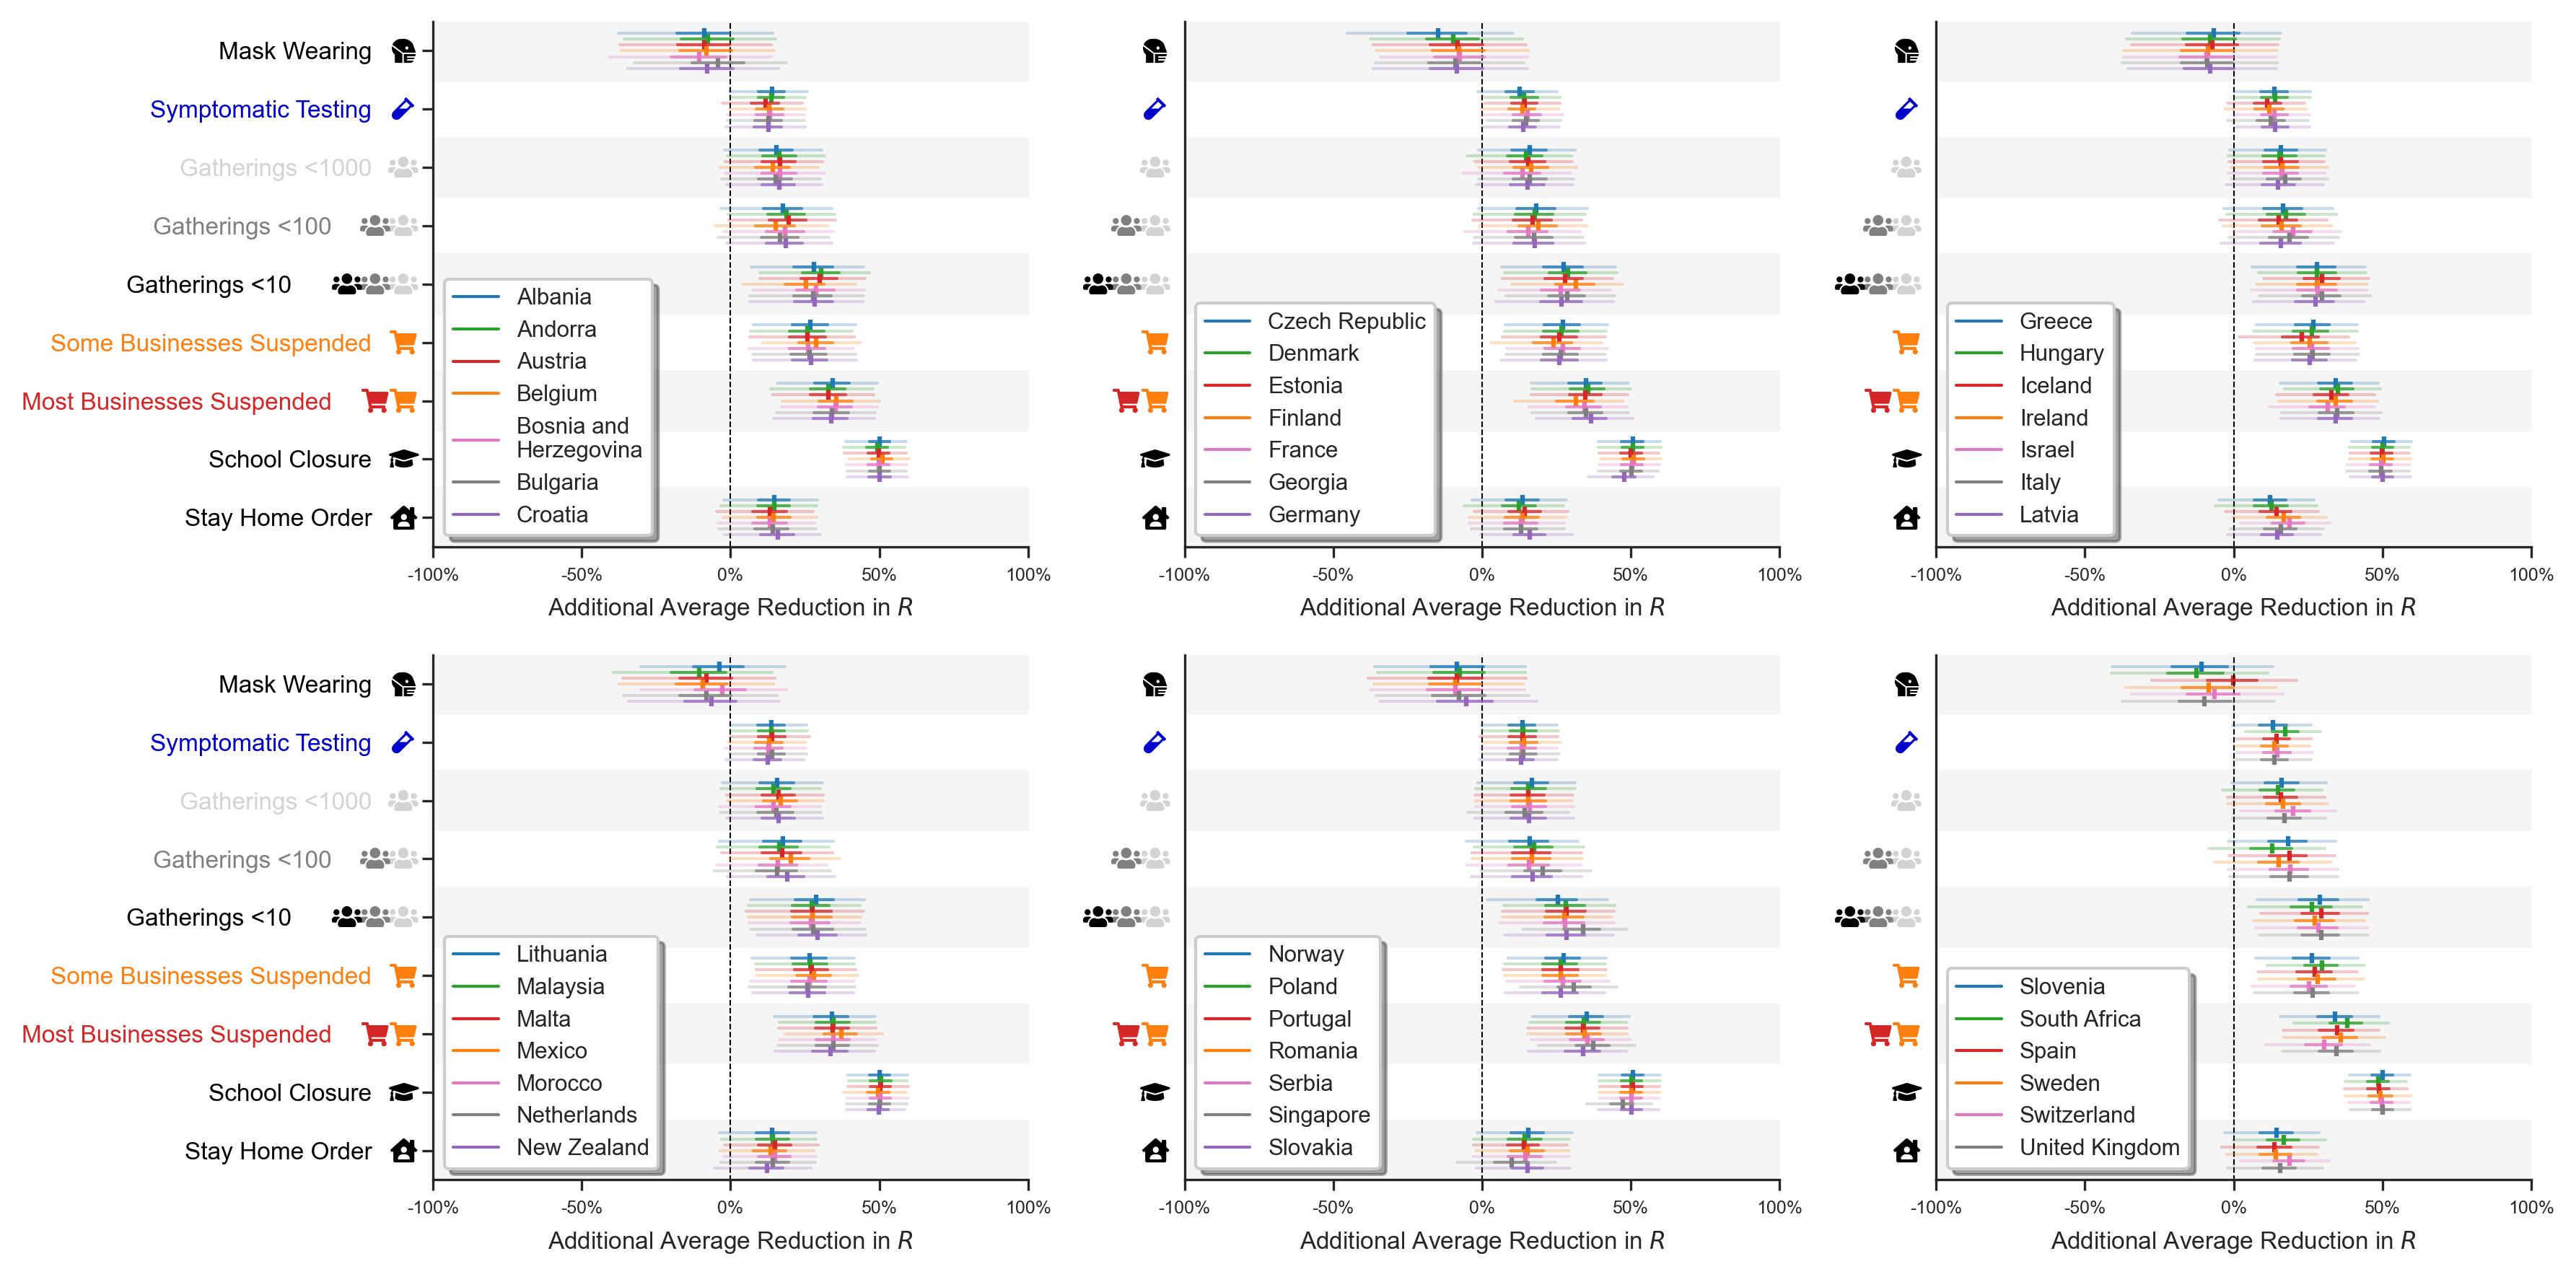

In [19]:
features = [x for x, _ in derived_features]
nF = len(features)

def add_region_to_plot(region, y_off, col):
    res = pickle.load(open(f"{region}.pkl", "rb")).CMReduction
    nS, _ = res.shape
    nF = len(derived_features)
    derived_samples = np.zeros((nS, nF))

    for f_i, (f, prodrows) in enumerate(derived_features):
        samples = np.ones(nS)
        for r in prodrows:
            samples = samples * res[:, r] 
        derived_samples[:, f_i] = samples

    res = derived_samples
    res = 100*(1-res)
    
    plt.plot([-10, -10], [-10, -10], col, linewidth=1, label=data.RNames[region][0].replace("and ", "and\n"))
    mn, med, li, ui, lq, uq = produce_ranges(res)
    plt.scatter(med, y_vals+y_off, marker="|", color=col, s=10)
    for cm in range(nF):
        plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], col, alpha=0.25, linewidth=1)
        plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], col, alpha=0.75, linewidth=1)

num_sets = int(len(data.Rs)/7) + 1
fig = plt.figure(figsize=(12, 6), dpi=300)

for rs in range(num_sets):
    regions = data.Rs[rs*7:(rs+1)*7]
    y_vals = -1 * np.arange(nF)
    plt.subplot(2, 3, rs+1)
    xrange = np.array([-100, 100])
    
    plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
    for height in range(0, nF, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="whitesmoke")

    x_min = -100
    x_max = 100
    plt.xlim([x_min, x_max])
    xtick_vals = np.arange(-100, 150, 50)
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    plt.ylim([-(nF - 0.5), 0.5])

    x_r = np.abs(x_min - x_max)
    for cm in range(nF):
        for i, val in enumerate(derived_features[cm][1]):
            plt.text(x_min - 0.05*x_r - 0.0475*x_r*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                         fontproperties=fp2, fontsize=8, color=cm_plot_style[val][1])

    
    if rs == 0 or rs == 3:
        plt.yticks(-np.arange(nF), [f"{f[0]}".ljust(len(f[0]) + 6*(len(f[1]))) for f in derived_features], fontsize=8)
        ax = plt.gca()
        for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
            ticklabel.set_color(cm_plot_style[i][1])
    else:
        plt.yticks([])

    y_offsets = np.linspace(0.3, -0.3, len(regions))
    colors = ["tab:blue", "tab:green", "tab:red", "tab:orange", "tab:pink", "tab:grey", "tab:purple"]
    for i, region in enumerate(regions):
        add_region_to_plot(region, y_offsets[i], colors[i])

    plt.xticks(xtick_vals, xtick_str, fontsize=6)
    plt.xlabel("Additional Average Reduction in $R$", fontsize=8)
    plt.legend(loc="lower left", fontsize=7.5, shadow=True, fancybox=True)

plt.tight_layout()
sns.despine()
plt.savefig(f"HOCountry_Set_{rs}.pdf",  bbox_inches='tight')